# Анализ задачи. Выбор признаков. Подбор гиперпараметров 

В своем ноутбуке мы постараемся подробно описать процесс работы с данными: анализ, результаты, мысли, замечания и выводы. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import os
import glob
from sklearn.ensemble import RandomForestClassifier

os.chdir('c:\\Projects\\sovcom\\AlphaHack') # наш путь к проекту

c:\Projects\sovcom\AlphaHack\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# подготовка данных (подгружаем train и test по примеру из бейзлайна) 

filenames_train = glob.glob('train' + "/*.csv")
data_files_train = []

for filename in filenames_train:
    data_files_train.append(pd.read_csv(filename))

data_train = pd.concat(data_files_train, ignore_index=True)

filenames_test = glob.glob('test' + "/*.csv")
data_files_test = []

for filename in filenames_test:
    data_files_test.append(pd.read_csv(filename))

data_test = pd.concat(data_files_test, ignore_index=True)

Для начала мы изучили датасет. Заметили, что в нем нет пропусков, вещественные признаки стандартизированы

In [ ]:
# общее число NaN
data_train.isna().sum().sum()

0

In [ ]:
data_train.describe()

,target,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
count,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,...,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000
mean,0.021766,19365.000000,-0.011868,-0.022720,0.240066,0.014769,0.002543,-0.121256,-0.021874,-0.212568,...,0.007855,-0.289571,0.046371,-0.011372,-0.045371,-0.009627,0.010300,-0.019660,-0.007003,-0.026602
std,0.145919,11180.820975,0.992397,0.991483,0.427129,1.006943,1.008098,0.983779,0.979137,0.935391,...,0.994804,0.806576,0.250005,0.998106,0.978557,0.972842,1.006719,0.990136,1.004295,0.987498
min,0.000000,0.000000,-5.199338,-5.199338,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-3.232688,-5.199338,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-3.408886,-5.199338,-5.199338
25%,0.000000,9682.500000,-0.681368,-0.693879,0.000000,-0.667434,-0.684292,-0.777239,-0.671211,-0.833827,...,-0.671584,-0.816589,0.000000,-0.694098,-0.700684,-0.676811,-0.676359,-0.687918,-0.678918,-0.692241
50%,0.000000,19365.000000,-0.014384,-0.014327,0.000000,0.025820,0.005269,-0.166902,-0.021997,-0.207170,...,0.017161,-0.216972,0.000000,-0.016165,-0.035410,-0.000174,0.020541,-0.018817,-0.012701,-0.030068
75%,0.000000,29047.500000,0.658456,0.651838,0.000000,0.706342,0.682534,0.566233,0.637608,0.407831,...,0.681021,0.320220,0.000000,0.667831,0.629747,0.645590,0.694864,0.655448,0.666673,0.657315
max,1.000000,38730.000000,5.199338,5.199338,1.000000,5.199338,5.199338,2.722168,5.199338,5.199338,...,5.199338,1.395742,2.000000,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,3.585167


Затем мы посмотрели на бинарные и "категориальные" признаки. Кавычки здесь, поскольку нет гарантии, что это категория - ориентируемся на то, что признак выражен в целых числах

Мы пробовали рассматривать эти признаки как категории (one hot encoding и т.п.), но лучший результат получился без применения различных encoding'ов

In [6]:
binary_features = []

for col in data_train.columns:
    if len(data_train[col].unique()) == 2:
        binary_features.append(col)

binary_features.remove('target')
print(f"Количество бинарных признаков: {len(binary_features)}")

categorial_features = []

for col in data_train.columns:
    if len(data_train[col].unique()) < 50:
        categorial_features.append(col)

categorial_features.remove('target')
categorial_features.remove('smpl')

print(f'Количество "категориальных" признаков: {len(categorial_features)}')

Количество бинарных признаков: 3
Количество "категориальных" признаков: 37


Посмотрели на распределения самого таргета: имеем сильный дисбаланс в сторону одного из классов (вероятно, юридических лиц, которым можно выдать кредит)

<Axes: >

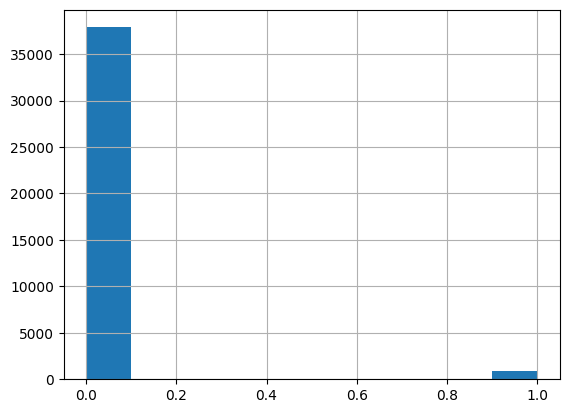

In [7]:
data_train['target'].hist()

Признаков довольно много, поэтому нам предстояло провести отбор, оставив только информативные.

Для этого сначала проанализировали распределения в зависимости от таргета. В коде приводим пример использования нашей функции на 10 признаках.

In [8]:
def plot_feature_distributions(df: pd.DataFrame, features: list[str], target: str='target') -> None:
    """
    Cтроит распределение для каждого признака в датасете в зависимости от бинарного таргета.
    """
    
    num_features = len(features)
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(12, 6 * num_features))
    
    for i, feature in enumerate(features):
        ax = axes[i] if num_features > 1 else axes
        sns.histplot(data=df, x=feature, hue=target, multiple="stack", kde=True, ax=ax)
        ax.set_title(f'Распределение {feature} в зависимости от {target}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()

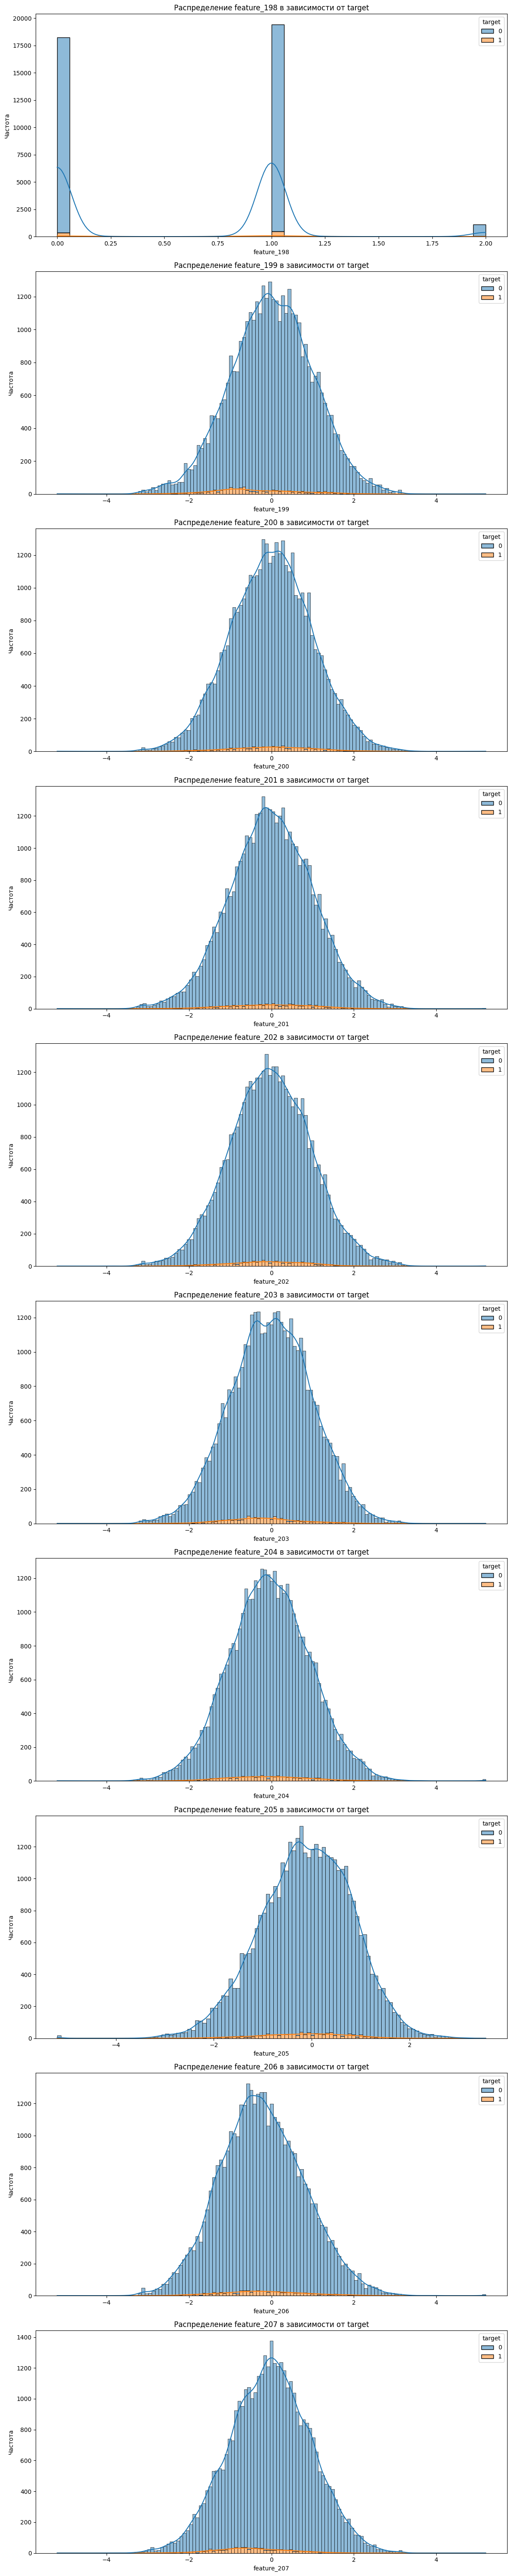

In [9]:
plot_feature_distributions(df=data_train, features=data_train.columns[200:210])

Изучив распределения всех признаков (418), мы не обнаружили явных сдвигов по распределениям признаков в зависимости от таргета.

Следующий важный шаг: анализ корреляций. Посмотрели, как признаки взаимодействуют друг с другом

In [10]:
def find_high_correlations(df: pd.DataFrame, threshold:float=0.9) -> None:
    """
    Находит и выводит пары признаков с корреляцией выше заданного порога.
    """
    corr_matrix = df.corr().abs()
    
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_pairs = [
        (col1, col2, upper_triangle.loc[col1, col2])
        for col1 in upper_triangle.columns
        for col2 in upper_triangle.index
        if upper_triangle.loc[col1, col2] > threshold
    ]
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} - {col2} - {corr_value:.2f}")

In [11]:
find_high_correlations(df=data_train.drop(['id', 'smpl'], axis=1))

feature_3 - feature_101 - 0.98
feature_3 - feature_330 - 0.94
feature_3 - feature_396 - 0.95
feature_17 - feature_23 - 0.98
feature_23 - feature_135 - 0.90
feature_101 - feature_330 - 0.98
feature_101 - feature_396 - 0.93
feature_135 - feature_341 - 0.92
feature_135 - feature_372 - 0.92
feature_160 - feature_269 - 0.96
feature_167 - feature_366 - 0.90
feature_278 - feature_358 - 0.94
feature_341 - feature_372 - 0.97


Видим, что корреляции есть. Необходимо учитывать эту информацию, чтобы при обучении модели избежать проблем мультиколлинеарности

Мы решили создать собственный "лидерборд" из признаков для того, чтобы отобрать наилучшие. Использовали следующие методы:

* Обучение логистической регрессии на каждом отдельном признаке с подсчетом roc auc

* Обучение градиентного бустинга с последующим анализом SHAP

* Stepwise алгоритм

In [12]:
X = data_train.drop(['id', 'smpl', 'target'], axis=1)
y = data_train['target']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# 1. Обучение лог-рега

def calculate_feature_auc(X_train, y_train, X_test, y_test):
    """Обучает логрег последовательно на каждом признаке и возвращает датасет с roc auc score для каждой фичи"""
    results = []
    

    for feature in X.columns:
        model = LogisticRegression(max_iter=1000, class_weight='balanced')
        model.fit(X_train[[feature]], y_train)
        y_pred_proba = model.predict_proba(X_test[[feature]])[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results.append((feature, roc_auc))

    results_df = pd.DataFrame(results, columns=['Feature', 'ROC-AUC logreg'])
    results_df.set_index('Feature', inplace=True)
    
    return results_df


In [15]:
features_leaderboard = calculate_feature_auc(X_train, y_train, X_test, y_test)
features_leaderboard


,ROC-AUC logreg
Feature,
feature_1,0.493159
feature_2,0.467271
feature_3,0.622926
feature_4,0.615552
feature_5,0.581937
...,...
feature_414,0.640739
feature_415,0.617307
feature_416,0.574785


In [16]:
# 2. Градиентный бустинг и SHAP

# Запускаем перебор параметров с помощью optuna

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1100),
        "depth": trial.suggest_int("depth", 4, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 3.0),
        "random_state": 42,
        "loss_function": "Logloss",
    }
    
    model = CatBoostClassifier(**param, verbose=0)
    model.fit(X_train, y_train)

    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    
    return auc

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # в реальности мы перебирали куда больше итераций :)

print("Лучшие гиперпараметры:", study.best_trial.params)
print("Лучший ROC AUC:", study.best_value)

[I 2024-11-14 12:35:46,809] A new study created in memory with name: no-name-c7841142-83f8-4fd5-a606-2e6bd06401a0
[I 2024-11-14 12:36:21,873] Trial 0 finished with value: 0.7806301642406155 and parameters: {'iterations': 511, 'depth': 7, 'learning_rate': 0.013383982008277296, 'l2_leaf_reg': 6.570877678093944, 'border_count': 150, 'random_strength': 0.11380965845209678, 'scale_pos_weight': 1.8319431614618207}. Best is trial 0 with value: 0.7806301642406155.
[I 2024-11-14 12:37:32,493] Trial 1 finished with value: 0.6027960102507882 and parameters: {'iterations': 503, 'depth': 9, 'learning_rate': 0.20063405567251386, 'l2_leaf_reg': 0.0042842181169002605, 'border_count': 118, 'random_strength': 0.33920327660404714, 'scale_pos_weight': 0.9997495094666939}. Best is trial 0 with value: 0.7806301642406155.
[I 2024-11-14 12:37:51,353] Trial 2 finished with value: 0.7374656628265253 and parameters: {'iterations': 448, 'depth': 7, 'learning_rate': 0.1064743834664458, 'l2_leaf_reg': 9.67707232818

Лучшие гиперпараметры: {'iterations': 511, 'depth': 7, 'learning_rate': 0.013383982008277296, 'l2_leaf_reg': 6.570877678093944, 'border_count': 150, 'random_strength': 0.11380965845209678, 'scale_pos_weight': 1.8319431614618207}
Лучший ROC AUC: 0.7806301642406155


In [18]:
final_model = CatBoostClassifier(**study.best_trial.params)
final_model.fit(X_train, y_train)

0:	learn: 0.6717375	total: 80.7ms	remaining: 41.1s
1:	learn: 0.6514681	total: 144ms	remaining: 36.5s
2:	learn: 0.6324710	total: 201ms	remaining: 34s
3:	learn: 0.6140348	total: 259ms	remaining: 32.8s
4:	learn: 0.5957789	total: 324ms	remaining: 32.8s
5:	learn: 0.5783472	total: 385ms	remaining: 32.4s
6:	learn: 0.5618465	total: 446ms	remaining: 32.1s
7:	learn: 0.5463548	total: 504ms	remaining: 31.7s
8:	learn: 0.5308971	total: 567ms	remaining: 31.6s
9:	learn: 0.5159320	total: 632ms	remaining: 31.6s
10:	learn: 0.5015477	total: 701ms	remaining: 31.9s
11:	learn: 0.4886536	total: 761ms	remaining: 31.6s
12:	learn: 0.4755898	total: 823ms	remaining: 31.5s
13:	learn: 0.4629310	total: 886ms	remaining: 31.4s
14:	learn: 0.4506712	total: 945ms	remaining: 31.2s
15:	learn: 0.4396649	total: 1.01s	remaining: 31.4s
16:	learn: 0.4283175	total: 1.07s	remaining: 31.2s
17:	learn: 0.4175986	total: 1.14s	remaining: 31.1s
18:	learn: 0.4073226	total: 1.19s	remaining: 30.9s
19:	learn: 0.3974621	total: 1.25s	remainin

Теперь обучим модель с лучшими параметрами

In [19]:
final_model = CatBoostClassifier(**study.best_trial.params)
final_model.fit(X_train, y_train)

0:	learn: 0.6717375	total: 53.4ms	remaining: 27.2s
1:	learn: 0.6514681	total: 94.5ms	remaining: 24s
2:	learn: 0.6324710	total: 135ms	remaining: 22.9s
3:	learn: 0.6140348	total: 176ms	remaining: 22.3s
4:	learn: 0.5957789	total: 224ms	remaining: 22.6s
5:	learn: 0.5783472	total: 268ms	remaining: 22.6s
6:	learn: 0.5618465	total: 312ms	remaining: 22.5s
7:	learn: 0.5463548	total: 371ms	remaining: 23.3s
8:	learn: 0.5308971	total: 438ms	remaining: 24.4s
9:	learn: 0.5159320	total: 480ms	remaining: 24.1s
10:	learn: 0.5015477	total: 529ms	remaining: 24s
11:	learn: 0.4886536	total: 581ms	remaining: 24.1s
12:	learn: 0.4755898	total: 621ms	remaining: 23.8s
13:	learn: 0.4629310	total: 666ms	remaining: 23.7s
14:	learn: 0.4506712	total: 708ms	remaining: 23.4s
15:	learn: 0.4396649	total: 755ms	remaining: 23.3s
16:	learn: 0.4283175	total: 802ms	remaining: 23.3s
17:	learn: 0.4175986	total: 849ms	remaining: 23.3s
18:	learn: 0.4073226	total: 893ms	remaining: 23.1s
19:	learn: 0.3974621	total: 937ms	remaining

Посмотрим на SHAP, он поможет визуализировать то, как значения конкретных признаков влияют на предсказание модели

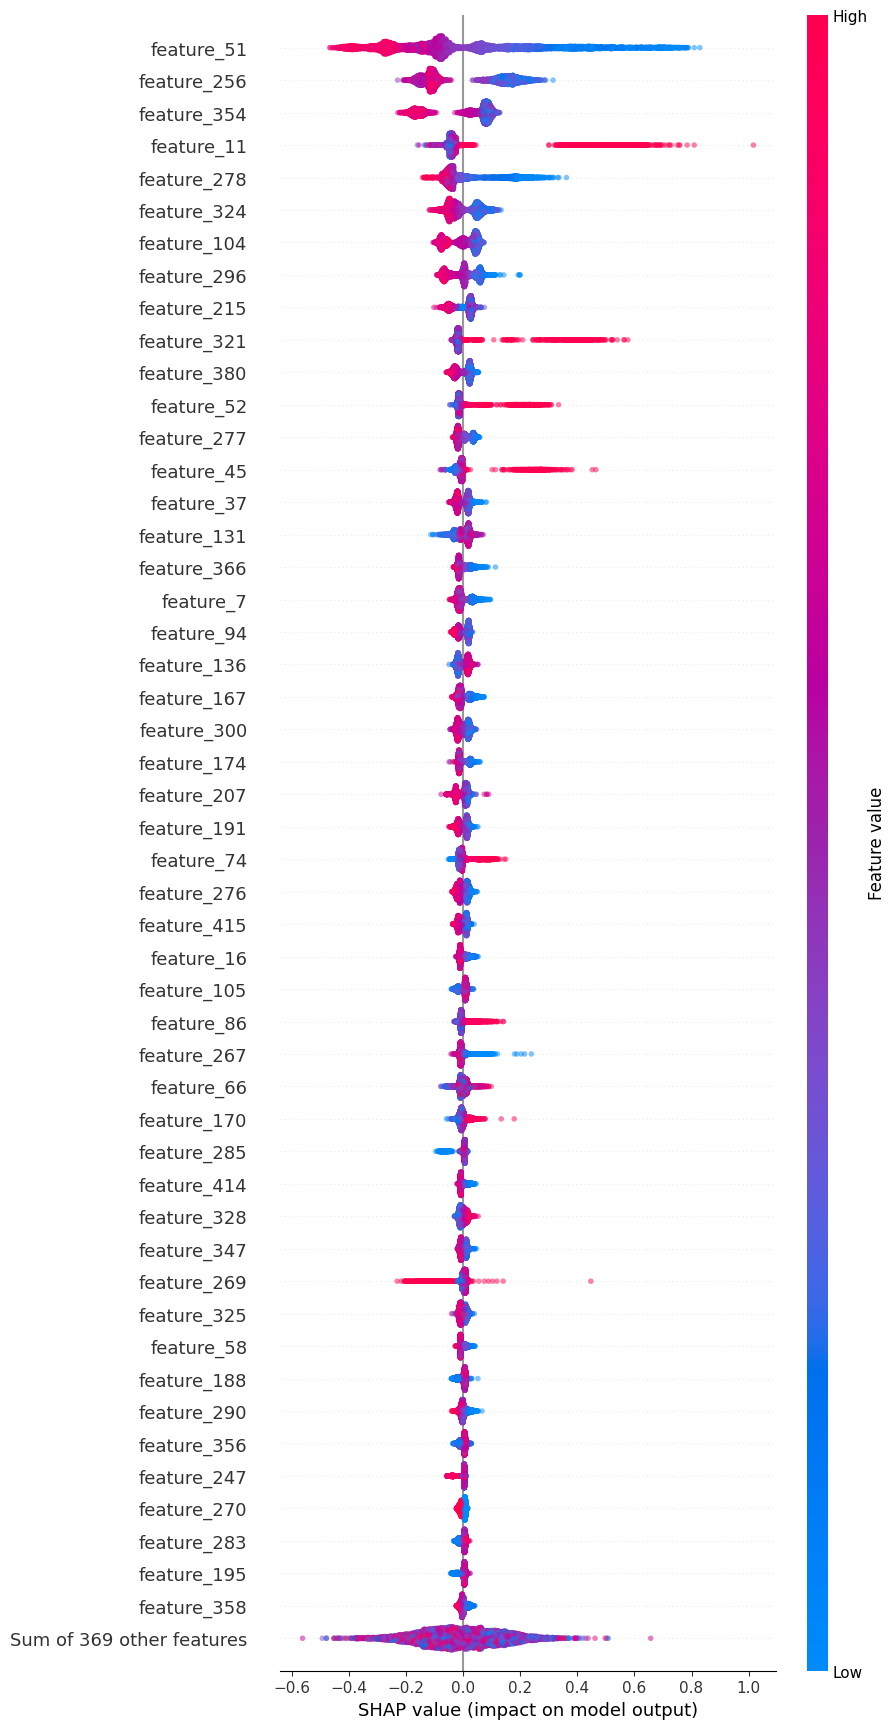

In [20]:
import shap
explainer = shap.Explainer(final_model)

shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=50, alpha=0.5, show=False)
plt.show()

Например, из этого графика можно заметить, что признак feature_51 важен для модели, причем более высокие значения направляют предсказание модели в сторону класса 0, а более низкие - в сторону класса 1.

Более наглядные графики для признаков (пример для трех, мы же анализировали все признаки)

In [21]:
def print_shap(feature):
    """Визуализирует, как значения признака влияют на предсказания модели"""
    fig, ax = plt.subplots(figsize=(12,6))

    shap_values_feature = shap_values[:, feature]

    try:
        shap.plots.scatter(shap_values_feature, color=shap_values_feature, ax=ax)
    except:
        pass
    finally:
        plt.show()

feature_11


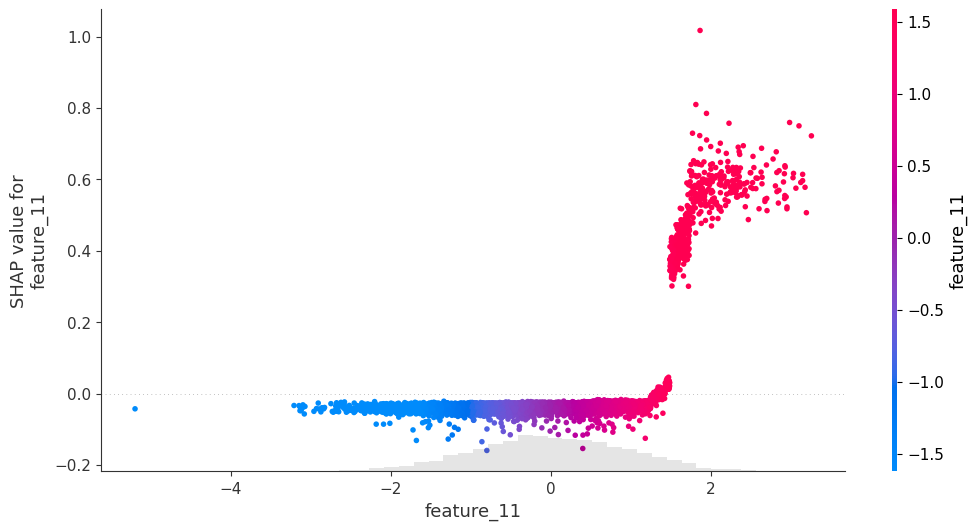

feature_12


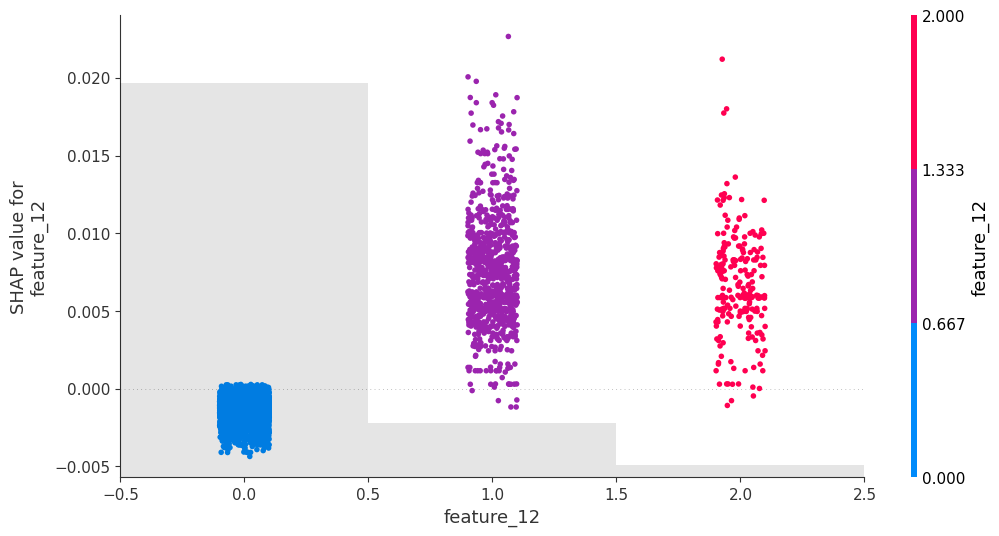

feature_13


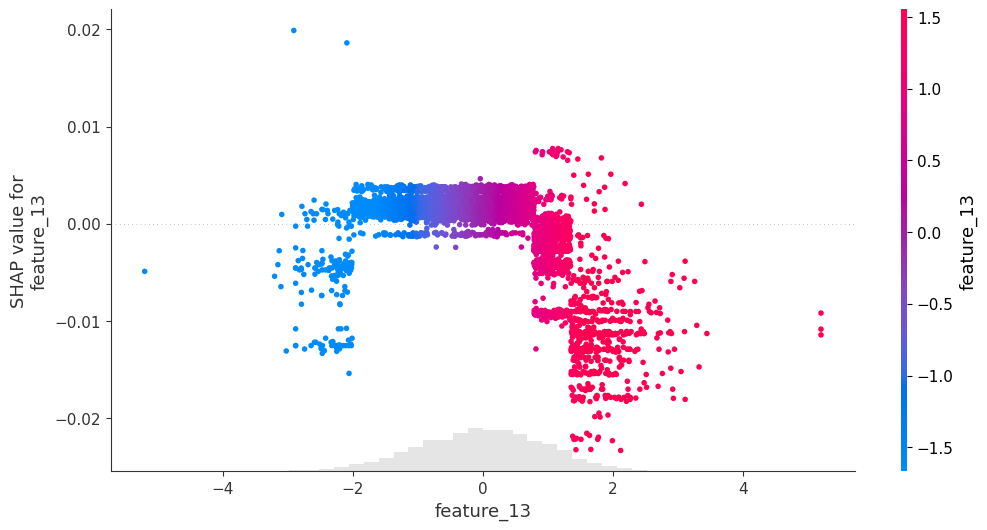

In [22]:
for feature in X.columns[10:13]:
    print(feature)
    print_shap(feature)

Например, для признака feature_11, низкие значения характерны для класса 0, а экстремально высокие (в рамках признака) - для класса 1.

Чтобы выразить важность признака численно, воспользуемся:

In [23]:
importance_cb = final_model.get_feature_importance(type='FeatureImportance')
feature_names = final_model.feature_names_

importance_cb= pd.DataFrame({
    'Feature': feature_names,
    'Catboost Weights': importance_cb
})

importance_cb.set_index('Feature', inplace=True)

Обновим информацию о признаках. Важно, что мы не ориентируемся на абсолютные значения, а ранжируем признаки относительно своей позиции в каждом столбце

In [24]:
features_leaderboard = pd.merge(features_leaderboard, importance_cb, how='inner', left_index=True, right_index=True)
features_leaderboard

,ROC-AUC logreg,Catboost Weights
Feature,,
feature_1,0.493159,0.118526
feature_2,0.467271,0.052730
feature_3,0.622926,0.000000
feature_4,0.615552,0.010074
feature_5,0.581937,0.149284
...,...,...
feature_414,0.640739,0.331224
feature_415,0.617307,0.356399
feature_416,0.574785,0.278175


In [25]:
# 3. Stepwise-алгоритм

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05):
    """
    Проводит пошаговый отбор признаков для логистической регрессии.
    
    :param X: pd.DataFrame — матрица признаков
    :param y: pd.Series — целевая переменная
    :param initial_list: list — начальный список признаков
    :param threshold_in: float — порог для добавления признака
    :param threshold_out: float — порог для удаления признака
    :param verbose: bool — выводить промежуточные результаты
    :return: список отобранных признаков
    """
    included = list(initial_list)
    
    while True:
        changed = False
        
        # Шаг вперёд
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_col in excluded:
            model = sm.Logit(y, sm.add_constant(X[included + [new_col]])).fit(disp=0)
            new_pval[new_col] = model.pvalues[new_col]
        
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            
            print(f"Добавлен признак: {best_feature} с p-value {best_pval:.4f}")
        
        # Шаг назад
        model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]  # Исключаем p-value для константы
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            print(f"Удален признак: {worst_feature} с p-value {worst_pval:.4f}")
        
        if not changed:
            break

    return included

In [ ]:
selected_features = stepwise_selection(X, y, threshold_in=0.13, threshold_out=0.3)

In [ ]:
# Результаты stepwise:

Добавлен признак: feature_396 с p-value 0.0000
Добавлен признак: feature_51 с p-value 0.0000
Добавлен признак: feature_354 с p-value 0.0000
Добавлен признак: feature_45 с p-value 0.0000
Добавлен признак: feature_49 с p-value 0.0000
Добавлен признак: feature_330 с p-value 0.0000
Добавлен признак: feature_296 с p-value 0.0000
Добавлен признак: feature_11 с p-value 0.0000
Добавлен признак: feature_270 с p-value 0.0000
Добавлен признак: feature_256 с p-value 0.0000
Добавлен признак: feature_324 с p-value 0.0000
Добавлен признак: feature_52 с p-value 0.0001
Добавлен признак: feature_321 с p-value 0.0003
Добавлен признак: feature_355 с p-value 0.0011
Добавлен признак: feature_37 с p-value 0.0010
Добавлен признак: feature_327 с p-value 0.0014
Добавлен признак: feature_117 с p-value 0.0021
Добавлен признак: feature_358 с p-value 0.0031
Добавлен признак: feature_167 с p-value 0.0082
Добавлен признак: feature_74 с p-value 0.0079
Добавлен признак: feature_342 с p-value 0.0094
Добавлен признак: fe

для stepwise храним информацию о том, вошел ли в признак в отбор

In [30]:
features_leaderboard['Stepwise'] = features_leaderboard.index
features_leaderboard['Stepwise'] = features_leaderboard['Stepwise'].apply(lambda x: 1 if x in selected_features else 0)
features_leaderboard

,ROC-AUC logreg,Catboost Weights,Stepwise
Feature,,,
feature_1,0.493159,0.118526,0
feature_2,0.467271,0.052730,0
feature_3,0.622926,0.000000,0
feature_4,0.615552,0.010074,0
feature_5,0.581937,0.149284,0
...,...,...,...
feature_414,0.640739,0.331224,0
feature_415,0.617307,0.356399,0
feature_416,0.574785,0.278175,0


P.S. Мы также пробовали генерировать собственные признаки: 

* Min, Max (по семплу)
* Median, Mean (по семплу)
* Sin, cos для каждого признака
* Всевозможные попарные произведения

Новых признаков было довольно много, но они не привели нас к лучшим результатам. Кроме того, к новым признакам мы отнеслись с осторожностью, поскольку природа признаков нам неизвестна, и такие "произведения" в реальной жизни могут быть нелогичны.

Для того, чтобы определиться с окончательной версией набора признаков, мы обучали различные модели (Catboost, LogisticRegression, LightGBM, RandomForest, XGBoost) и загружали результаты на сайт, от которых отталкивались в дальнейшем.

Сначала мы пробовали обучать на 5 лучших признаках (которые хорошо себя показали по различным столбцам нашего лидерборда), затем постепенно добавляли по несколько штук. Итоговый набор состоит из 74 признаков и выглядит следующим образом:

In [31]:
selected_features = ['feature_396', 'feature_51', 'feature_354', 'feature_45', 'feature_324', 'feature_330', 
                    'feature_296', 'feature_11', 'feature_256', 'feature_270', 'feature_52', 'feature_321',
                    'feature_355', 'feature_117', 'feature_274', 'feature_358', 'feature_327', 'feature_216', 
                    'feature_342', 'feature_198', 'feature_167', 'feature_74', 'feature_291', 'feature_195',
                    'feature_288', 'feature_53', 'feature_83', 'feature_78', 'feature_227', 'feature_325',
                    'feature_328', 'feature_171', 'feature_131', 'feature_378', 'feature_386', 'feature_98',
                    'feature_179', 'feature_243', 'feature_253', 'feature_49', 'feature_37', 'feature_136',
                    'feature_191', 'feature_177', 'feature_190', 'feature_170', 'feature_34', 'feature_25', 
                    'feature_123', 'feature_311', 'feature_229', 'feature_126', 'feature_282', 'feature_187', 
                    'feature_237', 'feature_21', 'feature_54', 'feature_12', 'feature_224', 'feature_279', 
                    'feature_104', 'feature_146', 'feature_174', 'feature_97', 'feature_94', 'feature_31', 
                    'feature_249', 'feature_213', 'feature_122', 'feature_86', 'feature_39', 'feature_17', 
                    'feature_119', 'feature_417']

In [ ]:
X = X[selected_features]

Следующий шаг: выбор модели и обучение гиперпараметров. Мы получили несколько моделей, которые показывали хороший результат на тесте (от 80.9 до 81.2)

Гиперпараметры для этих моделей подбирались на optuna:

In [ ]:
# Гиперпараметры для Catboost

def objective_cb(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 1100),
        "depth": trial.suggest_int("depth", 4, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 3.0),
        "verbose": 0,
        "random_state": 42,
        "loss_function": "Logloss",
    }

    model = CatBoostClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_, y_ = X.copy(), y.copy()
        X_train_fold, X_val_fold = X_.iloc[train_idx], X_.iloc[val_idx]
        y_train_fold, y_val_fold = y_.iloc[train_idx], y_.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=30, verbose=False)

        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_cb, n_trials=300)

print("Best Score:", study.best_value)
print("Best Parameters:", study.best_params)

In [ ]:
# Гиперпараметры для XGBoost

def objective_xgb(trial):
    params = {
        "objective": "binary:logistic",  
        "eval_metric": "logloss",      
        "early_stopping_rounds": 30,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0),    # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0),      # L1 regularization
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0),      # Regularization for splitting
        "random_state": 42,
    }

    model = xgb.XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_, y_ = X.copy(), y.copy()
        X_train_fold, X_val_fold = X_.iloc[train_idx], X_.iloc[val_idx]
        y_train_fold, y_val_fold = y_.iloc[train_idx], y_.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=300)

print("Best Score:", study.best_value)
print("Best Parameters:", study.best_params)

In [ ]:
# Гиперпараметры для RandomForest

def objective_rf(trial):
    
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 1300),
        "max_depth": trial.suggest_int('max_depth', 3, 20),
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 20),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 20),
        "max_features": trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        "bootstrap": trial.suggest_categorical('bootstrap', [True, False]),
        "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "n_jobs": -1,
        "random_state": 42
    }
    
    model = RandomForestClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_, y_ = X.copy(), y.copy()
        X_train_fold, X_val_fold = X_.iloc[train_idx], X_.iloc[val_idx]
        y_train_fold, y_val_fold = y_.iloc[train_idx], y_.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=300)

print("Лучшие гиперпараметры:", study.best_params)
print("Лучший ROC AUC score:", study.best_value)

In [ ]:
# Гиперпапраметры для LightGBM

def objective_lgb(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        # "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "random_state": 42,
        "early_stopping_rounds": 30,
        "verbosity": -1
    }

    model = lgb.LGBMClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_, y_ = X.copy(), y.copy()
        X_train_fold, X_val_fold = X_.iloc[train_idx], X_.iloc[val_idx]
        y_train_fold, y_val_fold = y_.iloc[train_idx], y_.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])
    
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lgb, n_trials=300)

print("Best Score:", study.best_value)
print("Best Parameters:", study.best_params)

Так, мы получили наилучшие параметры для каждой из моделей (их можно найти в итоговом пайплайне = training.ipynb). Потом мы решили собрать из них свой ансамбль для улучшения результата.

Для этого необходимо подобрать вес, с которым каждая модель будет входить в ансамбль. Веса подбирали также с помощью optuna и stratifiedKFold

Идея такая: фиксируем веса и будем считать roc-auc на каждом фолде, а затем вычислять гармоническое среднее. Это гармоническое среднее и будет целевой метрикой для оптимизации. Используем именно гармоническое, поскольку оно сильнее проседает, если один из фолдов получит низкое значение (например, для случая, когда на одном фолде 0.9, а на другом 0.6. Мы хотим получать хороший результат на всех фолдах)  

In [ ]:
def optimize_weights(X, y, n_splits=5):
    def objective(trial):

        best_params_cb = {
        "random_state": 42, 'iterations': 924, 'depth': 8, 'learning_rate': 0.011471190751683933, 
        'l2_leaf_reg': 8.495491043161323, 'border_count': 32, 'random_strength': 0.8839650630160032, 
        'scale_pos_weight': 0.901198554700845
        }

        best_params_xgb = {
            "random_state": 42, "eval_metric": "auc", "objective": "binary:logistic", 
            'learning_rate': 0.015500534976770255, 'max_depth': 6, 'min_child_weight': 1, 
            'subsample': 0.6506779163319192, 'colsample_bytree': 0.8715987661264806,
            'gamma': 0.3056460991480856, 'lambda': 1.171082066154121, 'alpha': 0.018116977426141514,
            'n_estimators': 247
        }

        best_params_rf = {
            "n_jobs": -1, "random_state": 42, 'n_estimators': 205, 'max_depth': 17, 'min_samples_split': 13, 
            'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'
        }
        best_params_lgb = {
            "verbosity": -1, "random_state": 42, 'boosting_type': 'gbdt', 'num_leaves': 83, 
            'max_depth': 7, 'learning_rate': 0.019724180534357524, 'n_estimators': 210, 
            'min_child_samples': 28, 'subsample': 0.6076221724692874, 'colsample_bytree': 0.6189622273306692, 
            'lambda_l1': 8.358629636915145, 'lambda_l2': 1.9778689270168646
        }
        # Генерируем веса для моделей
        w_rf = trial.suggest_float('w_rf', 0.0, 1.0)
        w_cb = trial.suggest_float('w_cb', 0.0, 1.0)
        w_lgb = trial.suggest_float('w_lgb', 0.0, 1.0)
        w_xgb = trial.suggest_float('w_xgb', 0.0, 1.0)
        
        # Нормализуем веса
        total_weight = w_rf + w_cb + w_lgb + w_xgb
        if total_weight == 0:
            return float('inf')  # исключаем случай, когда все веса нули
        
        w_rf /= total_weight
        w_cb /= total_weight
        w_lgb /= total_weight
        w_xgb /= total_weight

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = []
        
        for train_index, valid_index in skf.split(X, y):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            model_cb = CatBoostClassifier(**best_params_cb)
            model_lgb = lgb.LGBMClassifier(**best_params_lgb)
            model_xgb = xgb.XGBClassifier(**best_params_xgb)
            model_rf = RandomForestClassifier(**best_params_rf)
            
            model_rf.fit(X_train, y_train)
            model_lgb.fit(X_train, y_train)
            model_cb.fit(X_train, y_train, verbose=False)
            model_xgb.fit(X_train, y_train, verbose=False)
            
            preds_rf = model_rf.predict_proba(X_valid)[:, 1]
            preds_lgb = model_lgb.predict_proba(X_valid)[:, 1]
            preds_cb = model_cb.predict_proba(X_valid)[:, 1]
            preds_xgb = model_xgb.predict_proba(X_valid)[:, 1]

            ensemble_preds = (w_rf * preds_rf) + (w_cb * preds_cb) + (w_lgb * preds_lgb) + (w_xgb * preds_xgb)
            score = roc_auc_score(y_valid, ensemble_preds)
            scores.append(score)
        
        harmonic_mean = len(scores) / sum(1.0 / score for score in scores)
        print("scores:", scores)
        print("harmonic_mean:", harmonic_mean)
        print(w_rf, w_cb, w_lgb, w_xgb)
        print("------")
        return harmonic_mean 

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Best weights:")
    print(study.best_params)
    return study.best_params

In [ ]:
optimize_weights(X, y)

Полученные веса доступны в итоговом пайплайне. Это наше лучшее решение